### My plan
1. Load sliding-window data
2. Feature engineering: window into tabular features
3. Sanity checks + distribution plots
4. LightGBM training with class weights + early stopping
5. Threshold optimization on validation
6. First results + PR curve
7. 1D-CNN training

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score,
    precision_recall_curve, roc_curve
)
import lightgbm as lgb

W = 60    # lookback window (minutes)
H = 15    # prediction horizon (minutes)
DATASET_VERSION = 'v2'

METRIC_COLUMNS = [
    'cpu_utilization', 'memory_usage',
    'request_latency', 'error_rate', 'request_rate'
]
N_METRICS = len(METRIC_COLUMNS)

SEED = 42
np.random.seed(SEED)

print('LightGBM version:', lgb.__version__)
print(f'W={W}, H={H}, metrics={N_METRICS}')

LightGBM version: 4.6.0
W=60, H=15, metrics=5


In [3]:
npz_path = f'../data/sliding_window_{DATASET_VERSION}_W{W}_H{H}.npz'
data = np.load(npz_path, allow_pickle=True)

X_train_raw = data['X_train']   # shape: (N_train, W, M)
y_train     = data['y_train']   # shape: (N_train,)
X_val_raw   = data['X_val']
y_val       = data['y_val']
X_test_raw  = data['X_test']
y_test      = data['y_test']

train_indices = data['train_indices']
val_indices   = data['val_indices']
test_indices  = data['test_indices']

print('Loaded shapes:')
print(f'  X_train: {X_train_raw.shape} | y_train: {y_train.shape}')
print(f'  X_val:   {X_val_raw.shape}   | y_val:   {y_val.shape}')
print(f'  X_test:  {X_test_raw.shape}  | y_test:  {y_test.shape}')

print('\nClass balance:')
for name, y in [('train', y_train), ('val', y_val), ('test', y_test)]:
    pos = y.sum()
    print(f'  {name}: {pos}/{len(y)} positive ({100*pos/len(y):.1f}%)')

Loaded shapes:
  X_train: (12925, 60, 5) | y_train: (12925,)
  X_val:   (3925, 60, 5)   | y_val:   (3925,)
  X_test:  (2925, 60, 5)  | y_test:  (2925,)

Class balance:
  train: 291/12925 positive (2.3%)
  val: 57/3925 positive (1.5%)
  test: 331/2925 positive (11.3%)


In [4]:
def extract_features(X_windows: np.ndarray, metric_names: list) -> pd.DataFrame:
    """
      Window statistics: mean, std, min, max, median, p75, p95, range, CV
      Trend features: linear slope, last-vs-mean, last-vs-start, momentum
      Shock features: max single-step delta, z-score of last point, spike count
      Early-warning: stats over last k=10 points (recent sub-window)
      Cross-metric: Pearson corr between all metric pairs, domain ratios
    """
    N, W_len, M = X_windows.shape
    records = []

    for i in range(N):
        win = X_windows[i]   # shape (W, M)
        row = {}

        for m, name in enumerate(metric_names):
            v = win[:, m]
            row[f'{name}_mean']   = v.mean()
            row[f'{name}_std']    = v.std()
            row[f'{name}_min']    = v.min()
            row[f'{name}_max']    = v.max()
            row[f'{name}_median'] = np.median(v)
            row[f'{name}_p75']    = np.percentile(v, 75)
            row[f'{name}_p95']    = np.percentile(v, 95)
            row[f'{name}_range']  = v.max() - v.min()
            # Coefficient of variation (relative volatility)
            row[f'{name}_cv']     = v.std() / (v.mean() + 1e-9)

        t = np.arange(W_len, dtype=float)
        for m, name in enumerate(metric_names):
            v = win[:, m]
            slope = np.polyfit(t, v, 1)[0]
            row[f'{name}_slope']         = slope
            row[f'{name}_last_vs_mean']  = v[-1] - v.mean()
            row[f'{name}_last_vs_first'] = v[-1] - v[0]
            row[f'{name}_momentum']      = v[-5:].mean() - v[:5].mean()

        for m, name in enumerate(metric_names):
            v = win[:, m]
            diffs = np.abs(np.diff(v))
            # Largest single-step jump in window
            row[f'{name}_max_delta']    = diffs.max() if len(diffs) > 0 else 0
            # Z-score of last point relative to window
            std = v.std()
            row[f'{name}_zscore_last']  = (v[-1] - v.mean()) / (std + 1e-9)
            # Number of steps exceeding 2 std (spike count)
            row[f'{name}_spike_count']  = int((np.abs(v - v.mean()) > 2 * std).sum())

        K = 10
        recent = win[-K:, :]   # shape (K, M)
        for m, name in enumerate(metric_names):
            v_r = recent[:, m]
            row[f'{name}_recent_mean']  = v_r.mean()
            row[f'{name}_recent_std']   = v_r.std()
            row[f'{name}_recent_max']   = v_r.max()
            # Recent slope (trend in last K points)
            t_r = np.arange(K, dtype=float)
            row[f'{name}_recent_slope'] = np.polyfit(t_r, v_r, 1)[0]

        # Pearson correlations between all metric pairs
        for m1 in range(M):
            for m2 in range(m1 + 1, M):
                v1, v2 = win[:, m1], win[:, m2]
                std1, std2 = v1.std(), v2.std()
                if std1 > 1e-9 and std2 > 1e-9:
                    corr = np.corrcoef(v1, v2)[0, 1]
                else:
                    corr = 0.0
                n1, n2 = metric_names[m1], metric_names[m2]
                row[f'corr_{n1}__{n2}'] = corr

        # CPU / memory utilization ratio (resource saturation signal)
        cpu_mean = win[:, metric_names.index('cpu_utilization')].mean()
        mem_mean = win[:, metric_names.index('memory_usage')].mean()
        row['cpu_mem_ratio'] = cpu_mean / (mem_mean + 1e-9)

        # Error rate / request rate ratio (errors per request)
        err_mean = win[:, metric_names.index('error_rate')].mean()
        rps_mean = win[:, metric_names.index('request_rate')].mean()
        row['err_rps_ratio'] = err_mean / (rps_mean + 1e-9)

        # Latency x error_rate combined stress signal
        lat_mean = win[:, metric_names.index('request_latency')].mean()
        row['stress_signal'] = lat_mean * err_mean

        records.append(row)

    return pd.DataFrame(records)


X_train_feat = extract_features(X_train_raw, METRIC_COLUMNS)
X_val_feat   = extract_features(X_val_raw,   METRIC_COLUMNS)
X_test_feat  = extract_features(X_test_raw,  METRIC_COLUMNS)

print(f'Feature matrix shape: {X_train_feat.shape}')
print(f'Features per sample:  {X_train_feat.shape[1]}')
print('\nFeature groups summary:')
prefixes = ['_mean','_std','_slope','_zscore_last','_recent_mean','corr_','ratio','stress']
for g in prefixes:
    cols = [c for c in X_train_feat.columns if g in c]
    if cols:
        print(f'  {g:<22}: {len(cols)} features')

Feature matrix shape: (12925, 113)
Features per sample:  113

Feature groups summary:
  _mean                 : 15 features
  _std                  : 10 features
  _slope                : 10 features
  _zscore_last          : 5 features
  _recent_mean          : 5 features
  corr_                 : 10 features
  ratio                 : 2 features
  stress                : 1 features


In [5]:
print('=== NaN / Inf Check ===')
for name, df in [('train', X_train_feat), ('val', X_val_feat), ('test', X_test_feat)]:
    nan_count = df.isnull().sum().sum()
    inf_count = np.isinf(df.values).sum()
    status = 'OK' if (nan_count == 0 and inf_count == 0) else 'WARNING — filling with 0'
    print(f'  {name}: NaN={nan_count}, Inf={inf_count}  [{status}]')
    df.fillna(0, inplace=True)
    df.replace([np.inf, -np.inf], 0, inplace=True)

print('\n=== Class Imbalance ===')
scale_pos_weight = float((y_train == 0).sum()) / float((y_train == 1).sum())
print(f'scale_pos_weight (raw):    {scale_pos_weight:.1f}')
scale_pos_weight = min(scale_pos_weight, 20)
print(f'scale_pos_weight (capped): {scale_pos_weight:.1f}')
print(f'  Negative (train): {(y_train == 0).sum()}')
print(f'  Positive (train): {(y_train == 1).sum()}')
print(f'  scale_pos_weight: {scale_pos_weight:.2f}  (will be passed to LightGBM)')

print('\n=== Temporal Consistency ===')
print(f'  train indices: [{train_indices.min()}, {train_indices.max()}]')
print(f'  val   indices: [{val_indices.min()},   {val_indices.max()}]')
print(f'  test  indices: [{test_indices.min()},  {test_indices.max()}]')
assert train_indices.max() < val_indices.min(),  'LEAKAGE: train overlaps val!'
assert val_indices.max()   < test_indices.min(), 'LEAKAGE: val overlaps test!'
print('  OK — no temporal leakage')

=== NaN / Inf Check ===
  train: NaN=0, Inf=0  [OK]
  val: NaN=0, Inf=0  [OK]
  test: NaN=0, Inf=0  [OK]

=== Class Imbalance ===
scale_pos_weight (raw):    43.4
scale_pos_weight (capped): 20.0
  Negative (train): 12634
  Positive (train): 291
  scale_pos_weight: 20.00  (will be passed to LightGBM)

=== Temporal Consistency ===
  train indices: [60, 12984]
  val   indices: [13060,   16984]
  test  indices: [17060,  19984]
  OK — no temporal leakage


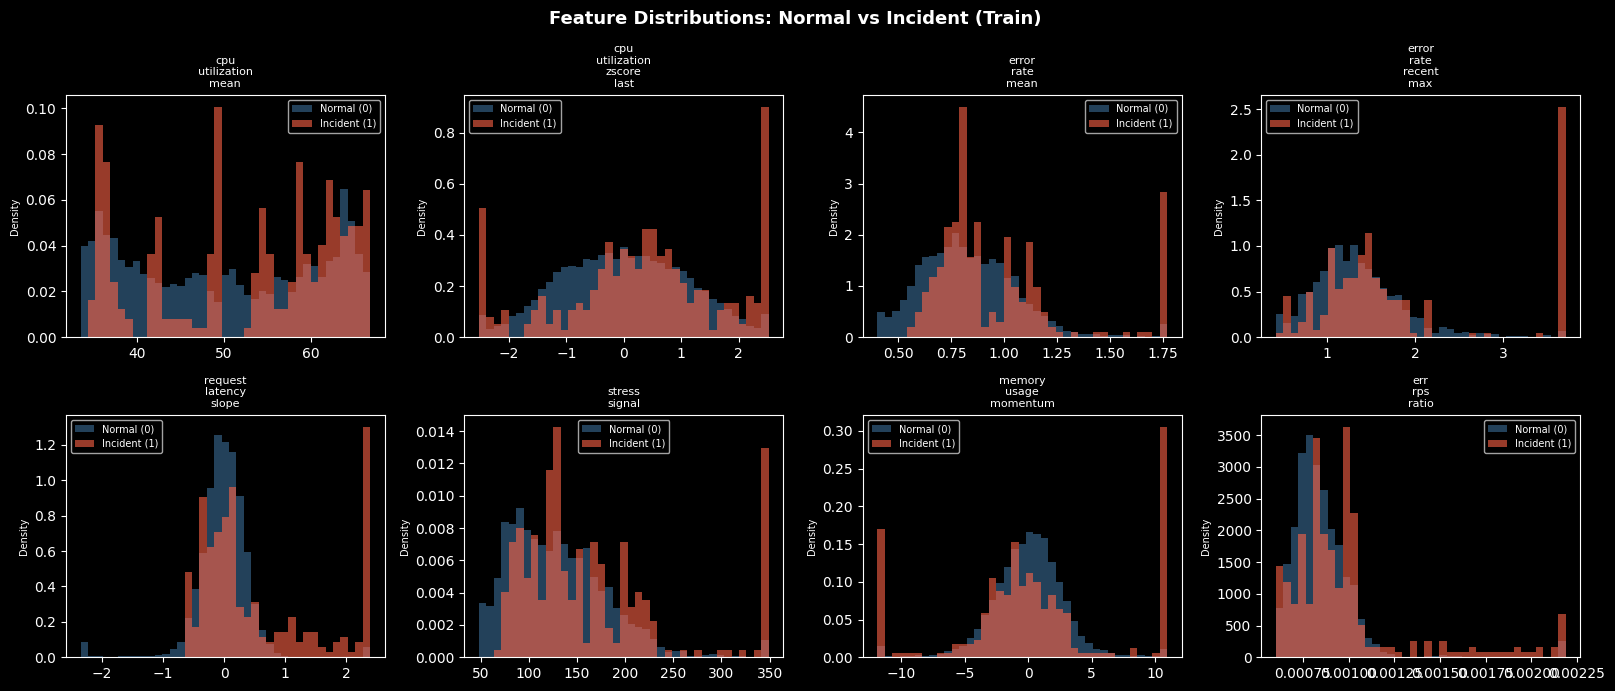

Saved: results/sanity_feature_distributions.png


In [6]:
key_features = [
    'cpu_utilization_mean', 'cpu_utilization_zscore_last',
    'error_rate_mean',       'error_rate_recent_max',
    'request_latency_slope', 'stress_signal',
    'memory_usage_momentum', 'err_rps_ratio'
]
key_features = [f for f in key_features if f in X_train_feat.columns]

fig, axes = plt.subplots(2, 4, figsize=(16, 7))
axes = axes.flatten()

for i, feat in enumerate(key_features[:8]):
    ax = axes[i]
    vals_neg = X_train_feat.loc[y_train == 0, feat].values
    vals_pos = X_train_feat.loc[y_train == 1, feat].values

    p1, p99 = np.percentile(X_train_feat[feat], [1, 99])
    bins = np.linspace(p1, p99, 40)

    ax.hist(vals_neg.clip(p1, p99), bins=bins, alpha=0.5, density=True,
            color='steelblue', label='Normal (0)')
    ax.hist(vals_pos.clip(p1, p99), bins=bins, alpha=0.6, density=True,
            color='tomato', label='Incident (1)')
    ax.set_title(feat.replace('_', '\n'), fontsize=8)
    ax.legend(fontsize=7)
    ax.set_ylabel('Density', fontsize=7)

fig.suptitle('Feature Distributions: Normal vs Incident (Train)', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('../results/sanity_feature_distributions.png', dpi=120, bbox_inches='tight')
plt.show()
print('Saved: results/sanity_feature_distributions.png')

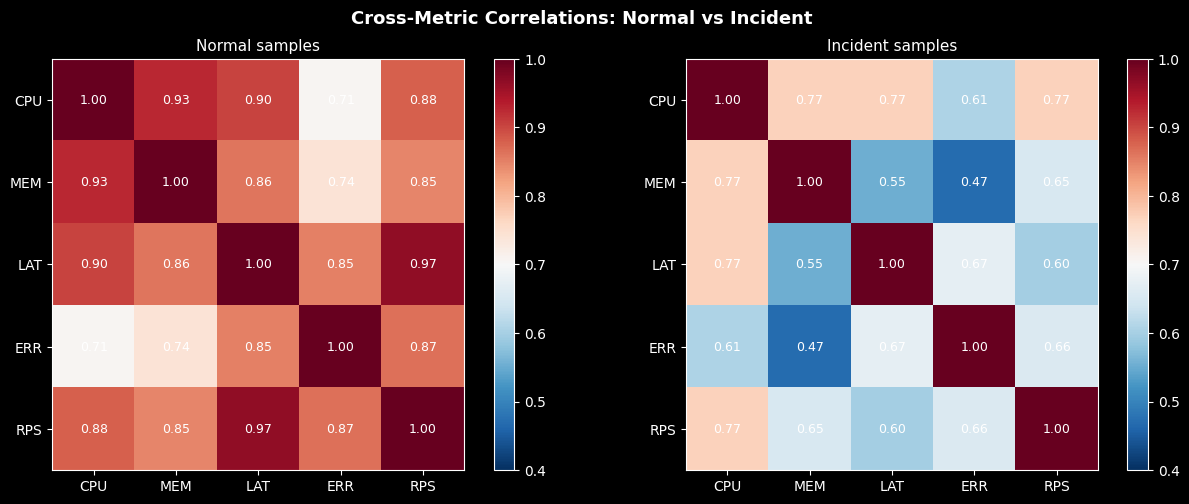

Saved: results/sanity_cross_metric_corr.png


In [8]:
corr_cols = [c for c in X_train_feat.columns if c.startswith('corr_')]
short = ['CPU', 'MEM', 'LAT', 'ERR', 'RPS']

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

for ax, label, mask in [
    (axes[0], 'Normal samples',   y_train == 0),
    (axes[1], 'Incident samples', y_train == 1)
]:
    corr_means = X_train_feat.loc[mask, corr_cols].mean()
    mat = np.eye(N_METRICS)
    idx = 0
    for m1 in range(N_METRICS):
        for m2 in range(m1+1, N_METRICS):
            v = float(corr_means.iloc[idx]) if idx < len(corr_means) else 0.0
            mat[m1, m2] = mat[m2, m1] = v
            idx += 1

    im = ax.imshow(mat, vmin=0.4, vmax=1, cmap='RdBu_r')
    ax.set_xticks(range(N_METRICS)); ax.set_xticklabels(short)
    ax.set_yticks(range(N_METRICS)); ax.set_yticklabels(short)
    for r in range(N_METRICS):
        for c in range(N_METRICS):
            ax.text(c, r, f'{mat[r,c]:.2f}', ha='center', va='center', fontsize=9)
    ax.set_title(f'{label}', fontsize=11)
    plt.colorbar(im, ax=ax)

fig.suptitle('Cross-Metric Correlations: Normal vs Incident', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('../results/sanity_cross_metric_corr.png', dpi=120, bbox_inches='tight')
plt.show()
print('Saved: results/sanity_cross_metric_corr.png')

In [9]:
feature_names = X_train_feat.columns.tolist()

dtrain = lgb.Dataset(
    X_train_feat.values, label=y_train,
    feature_name=feature_names, free_raw_data=False
)
dval = lgb.Dataset(
    X_val_feat.values, label=y_val,
    feature_name=feature_names, reference=dtrain, free_raw_data=False
)

params = {
    'objective':         'binary',
    'metric':            ['binary_logloss', 'auc'],
    'scale_pos_weight':  scale_pos_weight,
    'learning_rate':     0.05,
    'num_leaves':        15,
    'max_depth':         4,
    'min_child_samples': 50,
    'feature_fraction':  0.6,
    'bagging_fraction':  0.7,
    'bagging_freq':      5,
    'lambda_l1':         1.0,
    'lambda_l2':         1.0,
    'verbosity':         -1,
    'seed':              SEED,
}

print('Training LightGBM...')
print(f'  scale_pos_weight = {scale_pos_weight:.1f}')
print(f'  Features: {len(feature_names)}')

evals_result = {}
model_lgbm = lgb.train(
    params, dtrain,
    num_boost_round=500,
    valid_sets=[dtrain, dval],
    valid_names=['train', 'val'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50, verbose=False),
        lgb.log_evaluation(period=50),
        lgb.record_evaluation(evals_result)
    ]
)

print(f'\nBest iteration: {model_lgbm.best_iteration}')

Training LightGBM...
  scale_pos_weight = 20.0
  Features: 113
[50]	train's binary_logloss: 0.0530993	train's auc: 0.999312	val's binary_logloss: 0.0549763	val's auc: 0.946561

Best iteration: 16


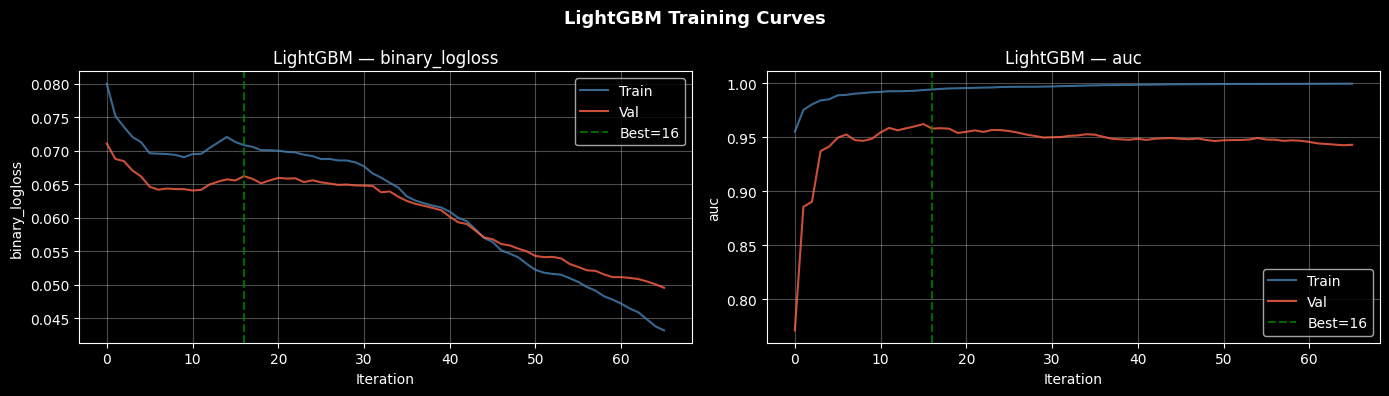

Saved: results/lgbm_training_curves.png


In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
for ax, metric in zip(axes, ['binary_logloss', 'auc']):
    if metric in evals_result.get('train', {}):
        ax.plot(evals_result['train'][metric], label='Train', color='steelblue', alpha=0.8)
    if metric in evals_result.get('val', {}):
        ax.plot(evals_result['val'][metric],   label='Val',   color='tomato',    alpha=0.8)
    ax.axvline(model_lgbm.best_iteration, color='green', linestyle='--',
               label=f'Best={model_lgbm.best_iteration}', alpha=0.8)
    ax.set_xlabel('Iteration'); ax.set_ylabel(metric)
    ax.set_title(f'LightGBM — {metric}'); ax.legend(); ax.grid(alpha=0.3)

plt.suptitle('LightGBM Training Curves', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('../results/lgbm_training_curves.png', dpi=120, bbox_inches='tight')
plt.show()
print('Saved: results/lgbm_training_curves.png')

Val  prob: min=0.0101 max=0.5898 mean=0.0496
Test prob: min=0.0100 max=0.7330 mean=0.0691


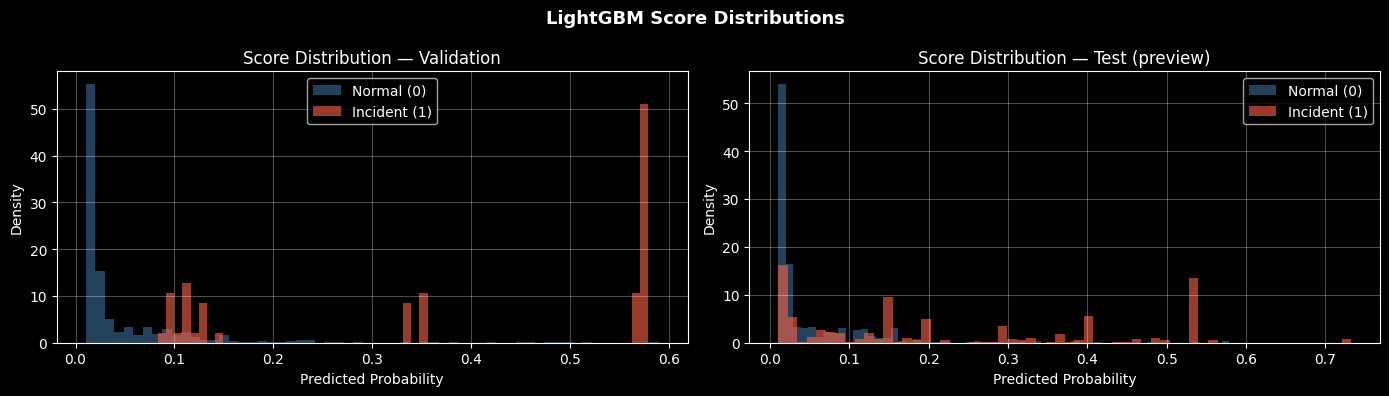

In [11]:
prob_val  = model_lgbm.predict(X_val_feat.values)
prob_test = model_lgbm.predict(X_test_feat.values)

print('Val  prob: min={:.4f} max={:.4f} mean={:.4f}'.format(prob_val.min(), prob_val.max(), prob_val.mean()))
print('Test prob: min={:.4f} max={:.4f} mean={:.4f}'.format(prob_test.min(), prob_test.max(), prob_test.mean()))

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
for ax, (probs, labels, title) in zip(axes, [
    (prob_val,  y_val,  'Validation'),
    (prob_test, y_test, 'Test (preview)')
]):
    ax.hist(probs[labels == 0], bins=60, alpha=0.5, density=True, color='steelblue', label='Normal (0)')
    ax.hist(probs[labels == 1], bins=60, alpha=0.6, density=True, color='tomato',    label='Incident (1)')
    ax.set_xlabel('Predicted Probability'); ax.set_ylabel('Density')
    ax.set_title(f'Score Distribution — {title}'); ax.legend(); ax.grid(alpha=0.3)

plt.suptitle('LightGBM Score Distributions', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('../results/lgbm_score_distributions.png', dpi=120, bbox_inches='tight')
plt.show()

In [12]:
thresholds = np.linspace(0.01, 0.99, 200)
recall_target = 0.80
results = []

for thr in thresholds:
    y_pred = (prob_val >= thr).astype(int)
    tp = ((y_pred==1) & (y_val==1)).sum()
    fp = ((y_pred==1) & (y_val==0)).sum()
    fn = ((y_pred==0) & (y_val==1)).sum()
    rec = tp / (tp + fn + 1e-9)
    pre = tp / (tp + fp + 1e-9)
    f1  = 2*pre*rec / (pre + rec + 1e-9)
    f2  = 5*pre*rec / (4*pre + rec + 1e-9)
    results.append({'threshold': thr, 'recall': rec, 'precision': pre, 'f1': f1, 'f2': f2})

results_df = pd.DataFrame(results)
candidates = results_df[results_df['recall'] >= recall_target]

if len(candidates) > 0:
    best_row = candidates.loc[candidates['precision'].idxmax()]
    THRESHOLD_OPT = best_row['threshold']
    print(f'Optimal threshold : {THRESHOLD_OPT:.4f}')
    print(f'  Val Recall      : {best_row["recall"]:.4f}')
    print(f'  Val Precision   : {best_row["precision"]:.4f}')
    print(f'  Val F1          : {best_row["f1"]:.4f}')
    print(f'  Val F2          : {best_row["f2"]:.4f}')
else:
    print('WARNING: No threshold hits recall >= 0.80 — using recall-max threshold')
    best_row = results_df.loc[results_df['recall'].idxmax()]
    THRESHOLD_OPT = best_row['threshold']
    print(f'  Best recall: {best_row["recall"]:.4f} @ {THRESHOLD_OPT:.4f}')

Optimal threshold : 0.1085
  Val Recall      : 0.8772
  Val Precision   : 0.1109
  Val F1          : 0.1969
  Val F2          : 0.3682


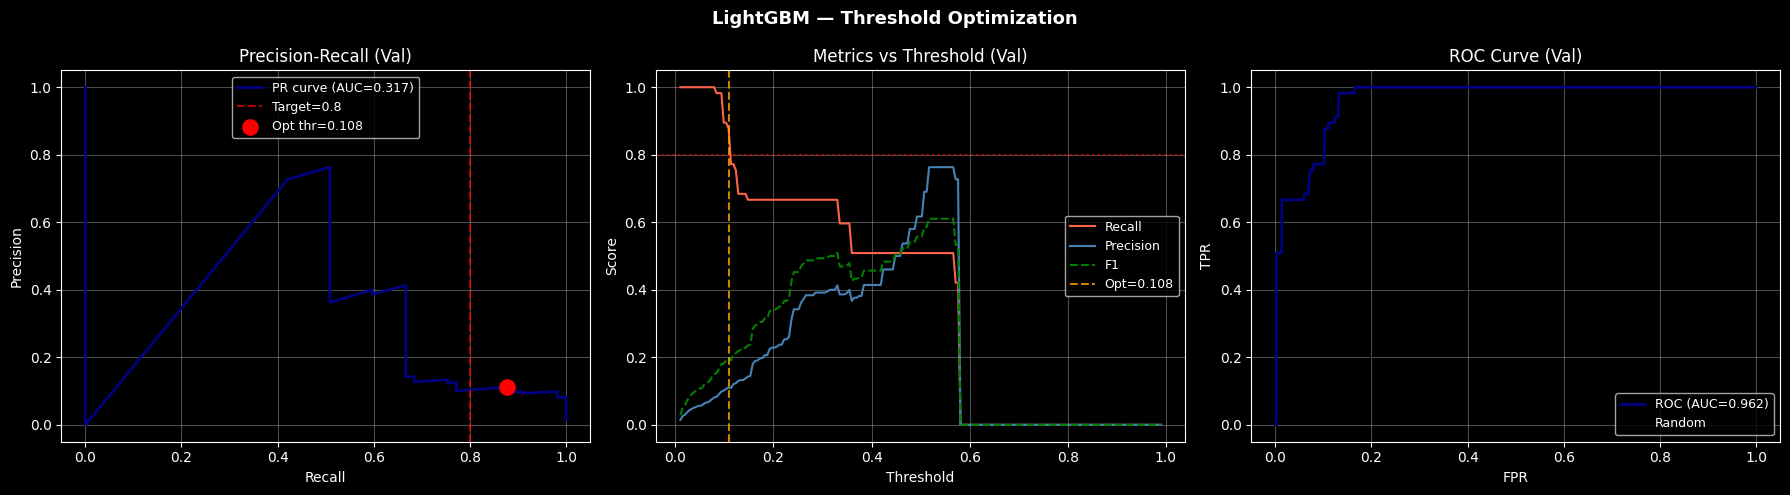

Saved: results/lgbm_threshold_curves.png


In [13]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

ax = axes[0]
prec_arr, rec_arr, _ = precision_recall_curve(y_val, prob_val)
auc_pr = np.trapezoid(prec_arr[::-1], rec_arr[::-1])
ax.plot(rec_arr, prec_arr, color='navy', lw=2, label=f'PR curve (AUC={auc_pr:.3f})')
ax.axvline(recall_target, color='red', linestyle='--', alpha=0.7, label=f'Target={recall_target}')
ax.scatter([best_row['recall']], [best_row['precision']], color='red', s=120, zorder=5,
           label=f'Opt thr={THRESHOLD_OPT:.3f}')
ax.set_xlabel('Recall'); ax.set_ylabel('Precision')
ax.set_title('Precision-Recall (Val)'); ax.legend(fontsize=9); ax.grid(alpha=0.3)

ax = axes[1]
ax.plot(results_df['threshold'], results_df['recall'],    color='tomato',    label='Recall')
ax.plot(results_df['threshold'], results_df['precision'], color='steelblue', label='Precision')
ax.plot(results_df['threshold'], results_df['f1'],        color='green', ls='--', label='F1')
ax.axhline(recall_target, color='red', linestyle=':', alpha=0.7)
ax.axvline(THRESHOLD_OPT, color='orange', linestyle='--', alpha=0.8, label=f'Opt={THRESHOLD_OPT:.3f}')
ax.set_xlabel('Threshold'); ax.set_ylabel('Score')
ax.set_title('Metrics vs Threshold (Val)'); ax.legend(fontsize=9); ax.grid(alpha=0.3)

ax = axes[2]
fpr_arr, tpr_arr, _ = roc_curve(y_val, prob_val)
roc_auc = roc_auc_score(y_val, prob_val)
ax.plot(fpr_arr, tpr_arr, color='navy', lw=2, label=f'ROC (AUC={roc_auc:.3f})')
ax.plot([0,1],[0,1], 'k--', alpha=0.4, label='Random')
ax.set_xlabel('FPR'); ax.set_ylabel('TPR')
ax.set_title('ROC Curve (Val)'); ax.legend(fontsize=9); ax.grid(alpha=0.3)

plt.suptitle('LightGBM — Threshold Optimization', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('../results/lgbm_threshold_curves.png', dpi=120, bbox_inches='tight')
plt.show()
print('Saved: results/lgbm_threshold_curves.png')

In [14]:
def evaluate_split(probs, y_true, threshold, split_name):
    y_pred = (probs >= threshold).astype(int)
    tp = ((y_pred==1) & (y_true==1)).sum()
    fp = ((y_pred==1) & (y_true==0)).sum()
    tn = ((y_pred==0) & (y_true==0)).sum()
    fn = ((y_pred==0) & (y_true==1)).sum()
    rec = tp / (tp + fn + 1e-9)
    pre = tp / (tp + fp + 1e-9)
    f1  = 2*pre*rec / (pre + rec + 1e-9)
    f2  = 5*pre*rec / (4*pre + rec + 1e-9)
    print(f'\n=== {split_name} @ threshold={threshold:.4f} ===')
    print(f'  TP={tp}  FP={fp}  TN={tn}  FN={fn}')
    print(f'  Recall   : {rec:.4f}  {"OK" if rec >= 0.80 else "BELOW TARGET"}')
    print(f'  Precision: {pre:.4f}')
    print(f'  F1       : {f1:.4f}')
    print(f'  F2       : {f2:.4f}')
    print(f'  Alert %  : {y_pred.mean()*100:.2f}%')
    return {'tp':tp,'fp':fp,'tn':tn,'fn':fn,'recall':rec,'precision':pre,'f1':f1,'f2':f2,'y_pred':y_pred,'probs':probs}

val_results  = evaluate_split(prob_val,  y_val,  THRESHOLD_OPT, 'Validation')
test_results = evaluate_split(prob_test, y_test, THRESHOLD_OPT, 'TEST (final)')


=== Validation @ threshold=0.1085 ===
  TP=50  FP=401  TN=3467  FN=7
  Recall   : 0.8772  OK
  Precision: 0.1109
  F1       : 0.1969
  F2       : 0.3682
  Alert %  : 11.49%

=== TEST (final) @ threshold=0.1085 ===
  TP=210  FP=384  TN=2210  FN=121
  Recall   : 0.6344  BELOW TARGET
  Precision: 0.3535
  F1       : 0.4541
  F2       : 0.5474
  Alert %  : 20.31%


In [28]:
import json

with open(f'../src/incident_intervals_{DATASET_VERSION}_improved.json') as f:
    incident_intervals = json.load(f)

test_start_g = int(test_indices.min())
test_end_g   = int(test_indices.max()) + 1
y_pred_test  = test_results['y_pred']

lead_times = []
print(f'{"Scenario":<20} {"Start":>7} {"First Alert":>12} {"Lead Time":>10} {"Status"}')
print('-' * 65)

for inc in incident_intervals:
    s, e = int(inc['start_idx']), int(inc['end_idx'])
    if e <= test_start_g or s >= test_end_g:
        continue

    scenario = inc.get('scenario', 'unknown')

    # All alert positions BEFORE incident start (predictive alerts)
    pre_incident_mask = (test_indices < s) & (test_indices >= test_start_g)
    pre_alert_positions = test_indices[pre_incident_mask & (y_pred_test == 1)]

    if len(pre_alert_positions) > 0:
        first_alert_global = pre_alert_positions.max()  # latest alert before start
        lead_time = s - first_alert_global
        lead_times.append(lead_time)
        print(f'{scenario:<20} {s:>7} {first_alert_global:>12} {lead_time:>9}m  ✓')
    else:
        # Check if detected during incident (lead time = 0 or negative)
        during_mask = (test_indices >= s) & (test_indices < e)
        if during_mask.any() and y_pred_test[during_mask].any():
            print(f'{scenario:<20} {s:>7} {"during":>12} {"0":>9}m  ~ (during)')
        else:
            print(f'{scenario:<20} {s:>7} {"—":>12} {"—":>9}   ✗ MISSED')

print(f'\nLead time statistics (pre-incident alerts only):')
if lead_times:
    lt = np.array(lead_times)
    print(f'  Count  : {len(lt)} / {len([i for i in incident_intervals if int(i["end_idx"]) > test_start_g and int(i["start_idx"]) < test_end_g])} incidents')
    print(f'  Mean   : {lt.mean():.1f} min')
    print(f'  Median : {np.median(lt):.1f} min')
    print(f'  Min    : {lt.min()} min')
    print(f'  Max    : {lt.max()} min')
else:
    print('  No pre-incident alerts found')

Scenario               Start  First Alert  Lead Time Status
-----------------------------------------------------------------
service_crash          17416        17211       205m  ✓
traffic_spike          17968        17845       123m  ✓
traffic_spike          18651        18464       187m  ✓
backend_failure        19671        19555       116m  ✓

Lead time statistics (pre-incident alerts only):
  Count  : 4 / 4 incidents
  Mean   : 157.8 min
  Median : 155.0 min
  Min    : 116 min
  Max    : 205 min


In [29]:
def apply_alert_postprocessing(probs, threshold, k=2, m=3, cooldown=10):
    """
    K-of-M: fire alert if at least K of the last M scores exceed threshold.
    Cooldown: after firing, suppress new alerts for `cooldown` steps.

    k=2, m=3: 2 of last 3 minutes above threshold
    cooldown=10: 10-minute silence after each alert
    """
    n = len(probs)
    raw = (probs >= threshold).astype(int)
    alerts = np.zeros(n, dtype=int)
    cooldown_remaining = 0

    for i in range(n):
        if cooldown_remaining > 0:
            cooldown_remaining -= 1
            continue
        # K-of-M window
        window_start = max(0, i - m + 1)
        window = raw[window_start: i + 1]
        if window.sum() >= k:
            alerts[i] = 1
            cooldown_remaining = cooldown

    return alerts


# Test different K-of-M configs
print('=== Post-processing sensitivity (Test set) ===\n')
print(f'{"Config":<25} {"Events":>8} {"TP":>5} {"FP":>6} {"FN":>5} '
      f'{"Recall":>8} {"Prec":>7} {"Alerts/day":>11}')
print('-' * 80)

configs = [
    ('Raw (no filter)',    1, 1,  0),
    ('K=2/M=3 cd=10',     2, 3, 10),
    ('K=2/M=5 cd=10',     2, 5, 10),
    ('K=3/M=5 cd=10',     3, 5, 10),
    ('K=2/M=3 cd=20',     2, 3, 20),
]

best_configs = {}
for name, k, m, cd in configs:
    if k == 1 and m == 1:
        alerts = (prob_test >= THRESHOLD_OPT).astype(int)
    else:
        alerts = apply_alert_postprocessing(prob_test, THRESHOLD_OPT, k=k, m=m, cooldown=cd)

    tp = ((alerts==1) & (y_test==1)).sum()
    fp = ((alerts==1) & (y_test==0)).sum()
    fn = ((alerts==0) & (y_test==1)).sum()
    rec  = tp / (tp + fn + 1e-9)
    prec = tp / (tp + fp + 1e-9)

    # Count alert events (rising edges)
    n_alert_events = int(((alerts[1:]==1) & (alerts[:-1]==0)).sum() + (alerts[0]==1))
    alerts_per_day = n_alert_events / len(alerts) * 1440

    # Event recall
    detected, total = 0, 0
    for inc in incident_intervals:
        s, e = int(inc['start_idx']), int(inc['end_idx'])
        if e <= test_start_g or s >= test_end_g:
            continue
        total += 1
        local_mask = (test_indices >= s) & (test_indices < e)
        if local_mask.any() and alerts[local_mask].any():
            detected += 1
    ev_rec = detected / max(total, 1)

    print(f'{name:<25} {detected}/{total} ev={ev_rec:.2f}  '
          f'{tp:>4}  {fp:>5}  {fn:>4}  {rec:>7.3f}  {prec:>6.3f}  {alerts_per_day:>10.1f}')

    best_configs[name] = {'alerts': alerts, 'event_recall': ev_rec,
                          'precision': prec, 'recall': rec}

=== Post-processing sensitivity (Test set) ===

Config                      Events    TP     FP    FN   Recall    Prec  Alerts/day
--------------------------------------------------------------------------------
Raw (no filter)           4/4 ev=1.00   210    384   121    0.634   0.354        16.7
K=2/M=3 cd=10             4/4 ev=1.00    22     42   309    0.066   0.344        31.5
K=2/M=5 cd=10             4/4 ev=1.00    23     46   308    0.069   0.333        34.0
K=3/M=5 cd=10             4/4 ev=1.00    21     41   310    0.063   0.339        30.5
K=2/M=3 cd=20             4/4 ev=1.00    12     29   319    0.036   0.293        20.2


 Threshold   Recall    Prec     F2   Events/day  Ev.Recall
-------------------------------------------------------
    0.0500    0.722   0.258  0.531         19.7       1.00
    0.0700    0.689   0.284  0.536         19.7       1.00
    0.0900    0.656   0.329  0.547         16.2       1.00
    0.1085    0.634   0.354  0.547         16.7       1.00 <-- val threshold
    0.1500    0.477   0.438  0.469         14.8       1.00
    0.2000    0.399   0.617  0.429         11.8       1.00


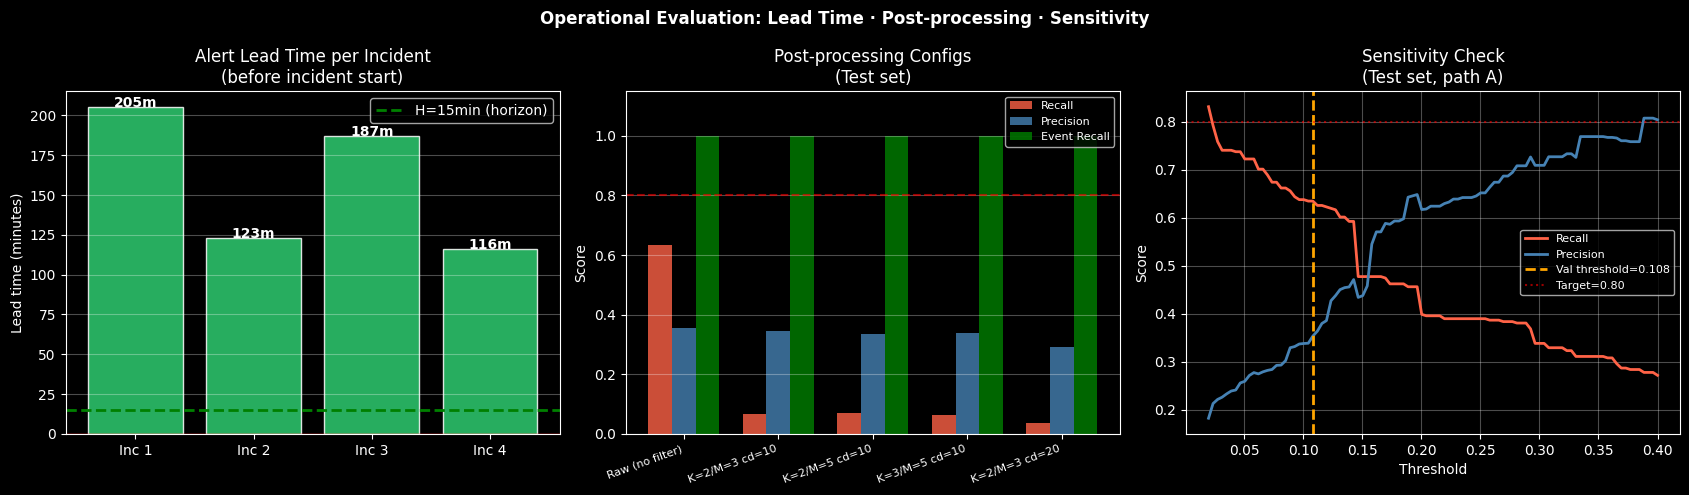

Saved: operational_evaluation.png


In [30]:
print(f'{"Threshold":>10} {"Recall":>8} {"Prec":>7} {"F2":>6} {"Events/day":>12} {"Ev.Recall":>10}')
print('-' * 55)

for thr in [0.05, 0.07, 0.09, THRESHOLD_OPT, 0.15, 0.20]:
    y_p = (prob_test >= thr).astype(int)
    tp  = ((y_p==1) & (y_test==1)).sum()
    fp  = ((y_p==1) & (y_test==0)).sum()
    fn  = ((y_p==0) & (y_test==1)).sum()
    rec  = tp / (tp + fn + 1e-9)
    pre  = tp / (tp + fp + 1e-9)
    f2   = 5*pre*rec / (4*pre + rec + 1e-9)
    n_ev = int(((y_p[1:]==1) & (y_p[:-1]==0)).sum() + (y_p[0]==1))
    evpd = n_ev / len(y_p) * 1440

    det, tot = 0, 0
    for inc in incident_intervals:
        s, e = int(inc['start_idx']), int(inc['end_idx'])
        if e <= test_start_g or s >= test_end_g: continue
        tot += 1
        lm = (test_indices >= s) & (test_indices < e)
        if lm.any() and y_p[lm].any(): det += 1
    ev_r = det / max(tot, 1)

    marker = ' <-- val threshold' if abs(thr - THRESHOLD_OPT) < 0.001 else ''
    print(f'{thr:>10.4f} {rec:>8.3f} {pre:>7.3f} {f2:>6.3f} {evpd:>12.1f} {ev_r:>10.2f}{marker}')


fig, axes = plt.subplots(1, 3, figsize=(17, 5))

ax = axes[0]
if lead_times:
    colors_lt = ['#2ecc71' if lt >= H else '#e74c3c' for lt in lead_times]
    labels_lt = [f'Inc {i+1}' for i in range(len(lead_times))]
    ax.bar(labels_lt, lead_times, color=colors_lt, alpha=0.85, edgecolor='white')
    ax.axhline(H, color='green', linestyle='--', lw=2, label=f'H={H}min (horizon)')
    ax.axhline(0, color='red',   linestyle='-',  lw=1)
    for i, lt in enumerate(lead_times):
        ax.text(i, lt + 0.3, f'{lt}m', ha='center', fontsize=10, fontweight='bold')
    ax.set_ylabel('Lead time (minutes)')
    ax.set_title('Alert Lead Time per Incident\n(before incident start)')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
else:
    ax.text(0.5, 0.5, 'No pre-incident\nalerts', ha='center', va='center',
            transform=ax.transAxes, fontsize=12)
    ax.set_title('Lead Time')

ax = axes[1]
cfg_names  = [c[0] for c in configs]
cfg_recall = [best_configs[c[0]]['recall']    for c in configs]
cfg_prec   = [best_configs[c[0]]['precision'] for c in configs]
cfg_ev     = [best_configs[c[0]]['event_recall'] for c in configs]
x = np.arange(len(cfg_names))
w = 0.25
ax.bar(x-w,  cfg_recall, w, label='Recall',        color='tomato',    alpha=0.8)
ax.bar(x,    cfg_prec,   w, label='Precision',     color='steelblue', alpha=0.8)
ax.bar(x+w,  cfg_ev,     w, label='Event Recall',  color='green',     alpha=0.8)
ax.axhline(0.80, color='red', ls='--', alpha=0.6)
ax.set_xticks(x)
ax.set_xticklabels(cfg_names, rotation=20, ha='right', fontsize=8)
ax.set_ylabel('Score')
ax.set_title('Post-processing Configs\n(Test set)')
ax.legend(fontsize=8)
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(0, 1.15)

ax = axes[2]
thr_range = np.linspace(0.02, 0.40, 100)
rec_curve, pre_curve = [], []
for thr in thr_range:
    y_p = (prob_test >= thr).astype(int)
    tp  = ((y_p==1) & (y_test==1)).sum()
    fp  = ((y_p==1) & (y_test==0)).sum()
    fn  = ((y_p==0) & (y_test==1)).sum()
    rec_curve.append(tp / (tp + fn + 1e-9))
    pre_curve.append(tp / (tp + fp + 1e-9))

ax.plot(thr_range, rec_curve, color='tomato',    lw=2, label='Recall')
ax.plot(thr_range, pre_curve, color='steelblue', lw=2, label='Precision')
ax.axvline(THRESHOLD_OPT, color='orange', ls='--', lw=2,
           label=f'Val threshold={THRESHOLD_OPT:.3f}')
ax.axhline(0.80, color='red', ls=':', alpha=0.6, label='Target=0.80')
ax.set_xlabel('Threshold')
ax.set_ylabel('Score')
ax.set_title('Sensitivity Check\n(Test set, path A)')
ax.legend(fontsize=8)
ax.grid(alpha=0.3)

plt.suptitle('Operational Evaluation: Lead Time · Post-processing · Sensitivity',
             fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('../results/operational_evaluation.png', dpi=120, bbox_inches='tight')
plt.show()
print('Saved: results/operational_evaluation.png')

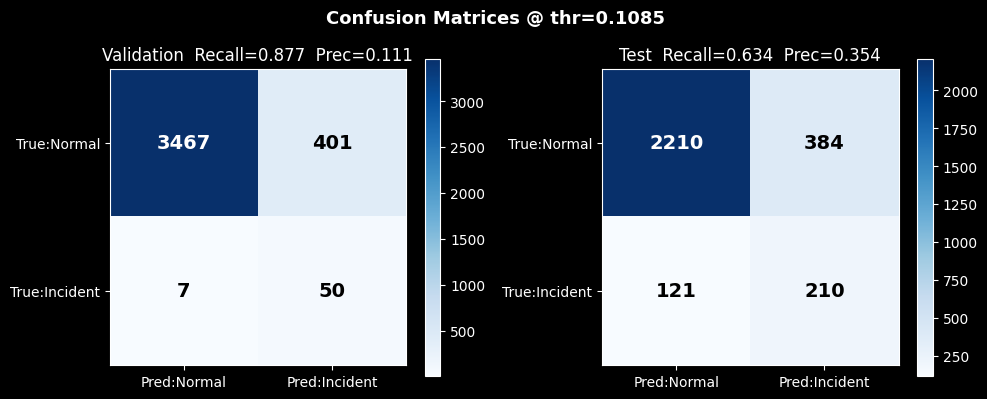

Saved: lgbm_confusion_matrices.png


In [31]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
for ax, res, title in [(axes[0], val_results, 'Validation'), (axes[1], test_results, 'Test')]:
    cm = np.array([[res['tn'], res['fp']], [res['fn'], res['tp']]])
    im = ax.imshow(cm, cmap='Blues')
    for r in range(2):
        for c in range(2):
            ax.text(c, r, str(cm[r,c]), ha='center', va='center', fontsize=14, fontweight='bold',
                    color='white' if cm[r,c] > cm.max()/2 else 'black')
    ax.set_xticks([0,1]); ax.set_yticks([0,1])
    ax.set_xticklabels(['Pred:Normal', 'Pred:Incident'])
    ax.set_yticklabels(['True:Normal', 'True:Incident'])
    ax.set_title(f'{title}  Recall={res["recall"]:.3f}  Prec={res["precision"]:.3f}')
    plt.colorbar(im, ax=ax)

plt.suptitle(f'Confusion Matrices @ thr={THRESHOLD_OPT:.4f}', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('../results/lgbm_confusion_matrices.png', dpi=120, bbox_inches='tight')
plt.show()
print('Saved: results/lgbm_confusion_matrices.png')

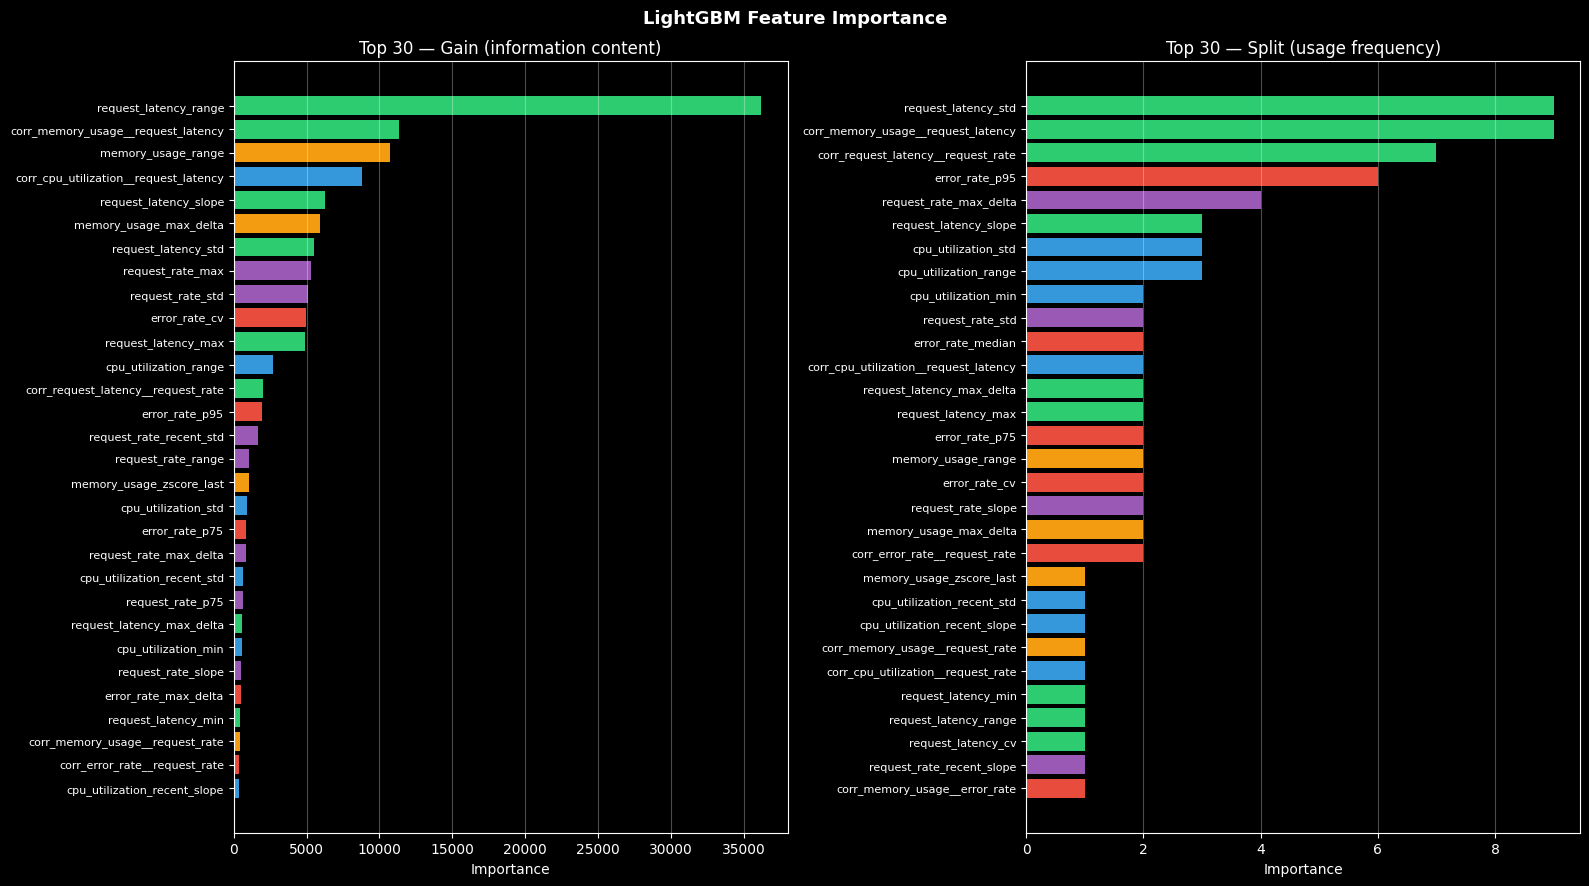


Top 10 by gain:
request_latency_range                    36187.199219
corr_memory_usage__request_latency       11324.424713
memory_usage_range                       10709.000488
corr_cpu_utilization__request_latency     8783.067627
request_latency_slope                     6281.827789
memory_usage_max_delta                    5917.509903
request_latency_std                       5483.484055
request_rate_max                          5282.950195
request_rate_std                          5080.958038
error_rate_cv                             4932.054962
dtype: float64


In [32]:
imp_gain  = pd.Series(model_lgbm.feature_importance('gain'),  index=feature_names).sort_values(ascending=False)
imp_split = pd.Series(model_lgbm.feature_importance('split'), index=feature_names).sort_values(ascending=False)
TOP_N = 30

fig, axes = plt.subplots(1, 2, figsize=(16, 9))
for ax, imp, title in [
    (axes[0], imp_gain,  'Gain (information content)'),
    (axes[1], imp_split, 'Split (usage frequency)')
]:
    top = imp.head(TOP_N)
    palette = {'error_rate':'#e74c3c','cpu':'#3498db','latency':'#2ecc71',
               'memory':'#f39c12','request_rate':'#9b59b6','corr':'#1abc9c',
               'stress':'#e67e22','err_rps':'#e74c3c'}
    colors = ['#e74c3c' if 'error' in n else
              '#3498db' if 'cpu'   in n else
              '#2ecc71' if 'laten' in n else
              '#f39c12' if 'mem'   in n else
              '#9b59b6' if 'rps'   in n or 'request_rate' in n else
              '#1abc9c' if 'corr'  in n else '#95a5a6'
              for n in top.index]
    ax.barh(range(TOP_N), top.values[::-1], color=colors[::-1])
    ax.set_yticks(range(TOP_N))
    ax.set_yticklabels(top.index[::-1], fontsize=8)
    ax.set_xlabel('Importance'); ax.set_title(f'Top {TOP_N} — {title}')
    ax.grid(axis='x', alpha=0.3)

plt.suptitle('LightGBM Feature Importance', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('../results/lgbm_feature_importance.png', dpi=120, bbox_inches='tight')
plt.show()
print('\nTop 10 by gain:')
print(imp_gain.head(10))

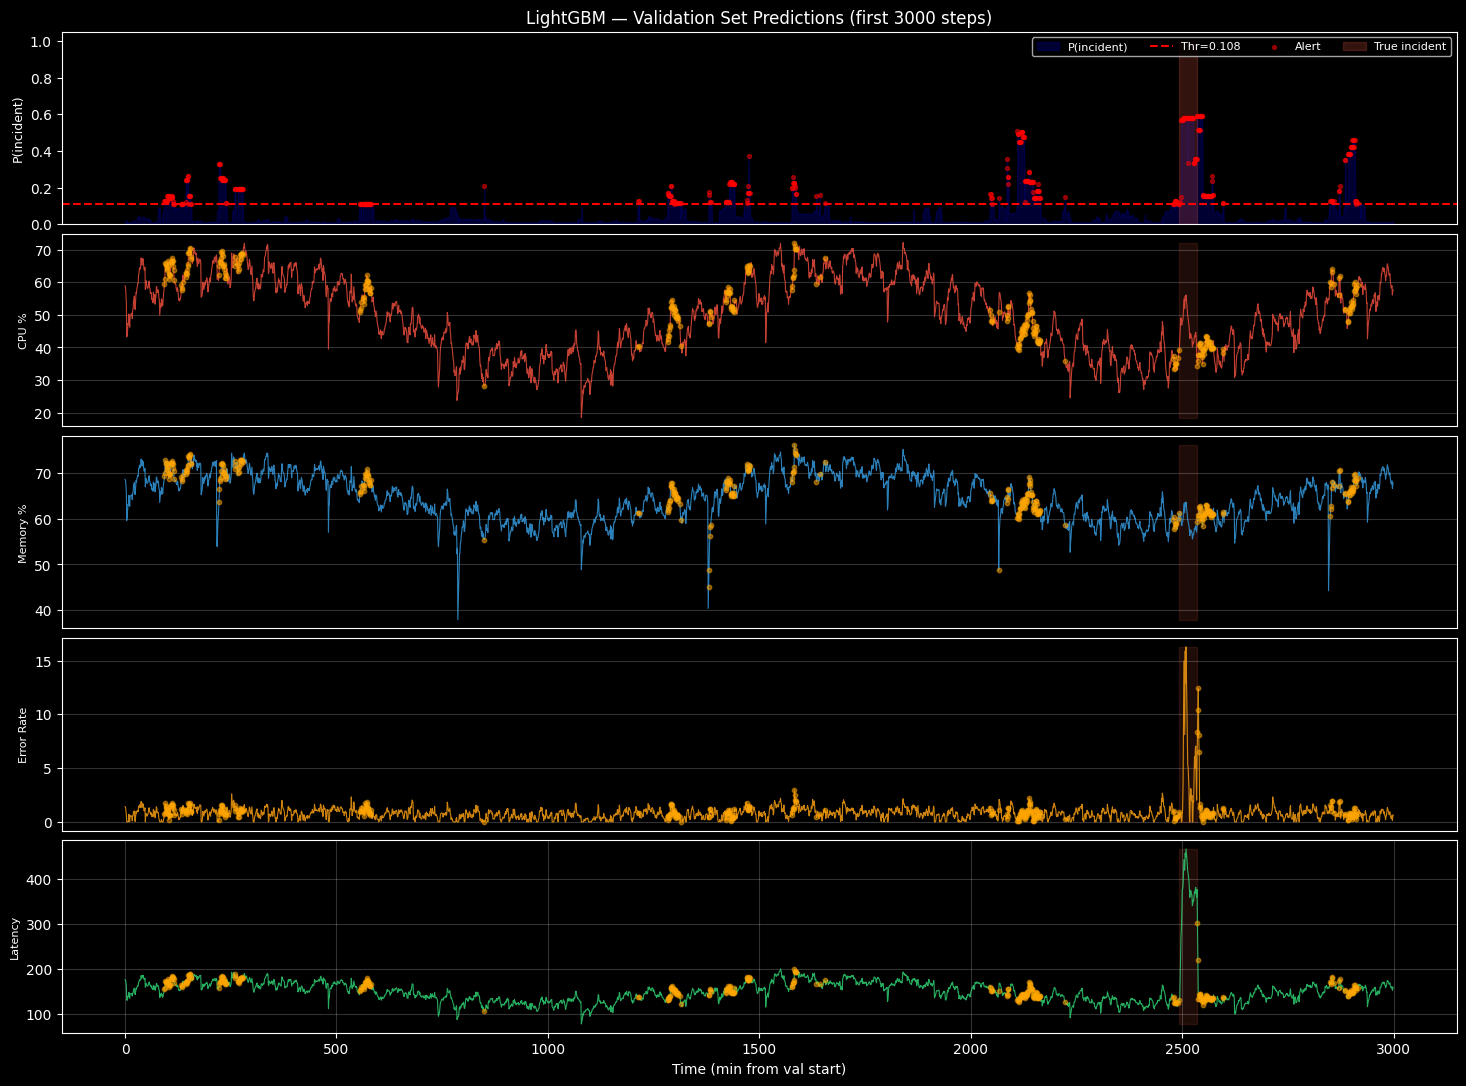

Saved: lgbm_temporal_predictions.png
  Red shade = true incident region | Orange dots = false alarms


In [33]:
df_orig = pd.read_csv(f'../data/synthetic_data_{DATASET_VERSION}_improved.csv')
df_orig['timestamp'] = pd.to_datetime(df_orig['timestamp'])

df_val_view = df_orig.iloc[val_indices].copy().reset_index(drop=True)
df_val_view['prob']  = prob_val
df_val_view['alert'] = (prob_val >= THRESHOLD_OPT).astype(int)

N_SHOW = min(3000, len(df_val_view))
dv = df_val_view.iloc[:N_SHOW]
incident_mask = dv['incident_label'].values == 1

fig = plt.figure(figsize=(18, 13))
gs  = gridspec.GridSpec(5, 1, hspace=0.05)

ax0 = fig.add_subplot(gs[0])
ax0.fill_between(range(N_SHOW), dv['prob'].values, alpha=0.4, color='navy', label='P(incident)')
ax0.axhline(THRESHOLD_OPT, color='red', linestyle='--', lw=1.5, label=f'Thr={THRESHOLD_OPT:.3f}')
ax0.scatter(np.where(dv['alert'].values==1)[0], dv['prob'].values[dv['alert'].values==1],
            color='red', s=8, alpha=0.5, zorder=5, label='Alert')
ax0.fill_between(range(N_SHOW), 0, 1, where=incident_mask, alpha=0.2, color='tomato', label='True incident')
ax0.set_ylabel('P(incident)', fontsize=9); ax0.set_ylim(0, 1.05)
ax0.legend(loc='upper right', fontsize=8, ncol=4)
ax0.set_xticks([])
ax0.set_title('LightGBM — Validation Set Predictions (first 3000 steps)', fontsize=12)

for i, (metric, color, ylabel) in enumerate([
    ('cpu_utilization', '#e74c3c', 'CPU %'),
    ('memory_usage',    '#3498db', 'Memory %'),
    ('error_rate',      '#f39c12', 'Error Rate'),
    ('request_latency', '#2ecc71', 'Latency'),
]):
    ax = fig.add_subplot(gs[i+1])
    ax.plot(dv[metric].values, color=color, lw=0.8, alpha=0.85)
    ax.fill_between(range(N_SHOW), dv[metric].min(), dv[metric].max(),
                    where=incident_mask, alpha=0.12, color='tomato')
    false_alarm_mask = (dv['alert'].values==1) & (~incident_mask)
    ax.scatter(np.where(false_alarm_mask)[0], dv[metric].values[false_alarm_mask],
               color='orange', s=10, alpha=0.5, zorder=5)
    ax.set_ylabel(ylabel, fontsize=8)
    ax.set_xticks([]) if i < 3 else ax.set_xlabel('Time (min from val start)')
    ax.grid(alpha=0.2)

plt.savefig('../results/lgbm_temporal_predictions.png', dpi=120, bbox_inches='tight')
plt.show()
print('Saved: lgbm_temporal_predictions.png')
print('  Red shade = true incident region | Orange dots = false alarms')

## 1D-CNN

In [16]:
try:
    import torch, torch.nn as nn
    from torch.utils.data import TensorDataset, DataLoader
    TORCH_AVAILABLE = True
    print(f'PyTorch {torch.__version__}')
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f'Device: {DEVICE}')
except ImportError:
    TORCH_AVAILABLE = False
    print('PyTorch not available. Install: pip install torch --break-system-packages')

PyTorch 2.10.0+cpu
Device: cpu


In [20]:
if TORCH_AVAILABLE:

    class CNN1D(nn.Module):
        """
        Three-block 1D-CNN.
        Input shape:  (batch, M=5, W=60)   [channels-first for Conv1d]
        Output shape: (batch,)              [logit]
        """
        def __init__(self, n_metrics, window):
            super().__init__()
            self.conv_blocks = nn.Sequential(
                # Block 1 — local patterns
                nn.Conv1d(n_metrics, 32, kernel_size=7, padding=3),
                nn.BatchNorm1d(32), nn.ReLU(), nn.MaxPool1d(2),
                # Block 2 — medium-range
                nn.Conv1d(32, 64, kernel_size=5, padding=2),
                nn.BatchNorm1d(64), nn.ReLU(), nn.MaxPool1d(2),
                # Block 3 — broader context
                nn.Conv1d(64, 128, kernel_size=3, padding=1),
                nn.BatchNorm1d(128), nn.ReLU(),
                nn.AdaptiveAvgPool1d(4)
            )
            self.head = nn.Sequential(
                nn.Flatten(),
                nn.Linear(128*4, 64), nn.ReLU(), nn.Dropout(0.3),
                nn.Linear(64, 1)
            )

        def forward(self, x):
            return self.head(self.conv_blocks(x)).squeeze(-1)


    def make_loader(X_raw, y, shuffle=False, batch=256):
        # (N, W, M) -> (N, M, W)  for Conv1d
        X_t = torch.FloatTensor(X_raw).permute(0, 2, 1)
        y_t = torch.FloatTensor(y)
        return DataLoader(TensorDataset(X_t, y_t), batch_size=batch, shuffle=shuffle)


    cnn_pos_weight = float(scale_pos_weight)
    model_cnn  = CNN1D(N_METRICS, W).to(DEVICE)
    criterion  = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([cnn_pos_weight]).to(DEVICE))
    optimizer  = torch.optim.Adam(model_cnn.parameters(), lr=1e-3, weight_decay=1e-4)
    scheduler  = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30, eta_min=1e-5)

    train_loader = make_loader(X_train_raw, y_train, shuffle=True)
    val_loader   = make_loader(X_val_raw,   y_val)

    n_params = sum(p.numel() for p in model_cnn.parameters())
    print(f'CNN parameters: {n_params:,} | pos_weight={cnn_pos_weight:.1f}')

else:
    print('Skipped')

CNN parameters: 69,505 | pos_weight=20.0


Ep   5 | train=0.1864 val=0.5498 auc=0.8302
Ep  10 | train=0.0843 val=2.0293 auc=0.4847
Early stopping at epoch 14

Best CNN val AUC: 0.9250


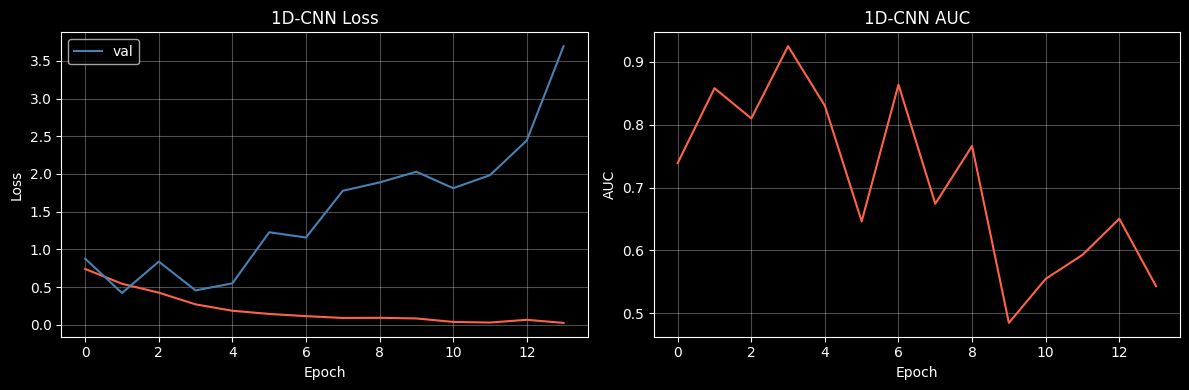

In [37]:
if TORCH_AVAILABLE:
    N_EPOCHS = 40
    patience, patience_ctr = 10, 0
    best_auc = 0
    cnn_hist = {'train_loss':[], 'val_loss':[], 'val_auc':[]}

    for epoch in range(N_EPOCHS):
        # Train
        model_cnn.train(); tloss = 0
        for Xb, yb in train_loader:
            Xb, yb = Xb.to(DEVICE), yb.to(DEVICE)
            optimizer.zero_grad()
            loss = criterion(model_cnn(Xb), yb)
            loss.backward()
            nn.utils.clip_grad_norm_(model_cnn.parameters(), 1.0)
            optimizer.step()
            tloss += loss.item()
        scheduler.step()

        # Validate
        model_cnn.eval(); vloss = 0; preds, labs = [], []
        with torch.no_grad():
            for Xb, yb in val_loader:
                Xb, yb = Xb.to(DEVICE), yb.to(DEVICE)
                logits = model_cnn(Xb)
                vloss += criterion(logits, yb).item()
                preds.extend(torch.sigmoid(logits).cpu().numpy())
                labs.extend(yb.cpu().numpy())

        val_auc = roc_auc_score(labs, preds)
        cnn_hist['train_loss'].append(tloss/len(train_loader))
        cnn_hist['val_loss'].append(vloss/len(val_loader))
        cnn_hist['val_auc'].append(val_auc)

        if val_auc > best_auc:
            best_auc = val_auc
            best_cnn_probs_val = np.array(preds)
            torch.save(model_cnn.state_dict(), 'best_cnn.pt')
            patience_ctr = 0
        else:
            patience_ctr += 1

        if (epoch+1) % 5 == 0:
            tag = ' <- best' if patience_ctr == 0 else ''
            print(f'Ep {epoch+1:3d} | train={cnn_hist["train_loss"][-1]:.4f} '
                  f'val={cnn_hist["val_loss"][-1]:.4f} auc={val_auc:.4f}{tag}')

        if patience_ctr >= patience:
            print(f'Early stopping at epoch {epoch+1}'); break

    print(f'\nBest CNN val AUC: {best_auc:.4f}')

    # Training curves
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    for ax, key, ylabel in [
        (axes[0], 'train_loss', 'Loss'),
        (axes[1], 'val_auc',    'AUC')
    ]:
        ax.plot(cnn_hist[key], color='tomato')
        if key == 'train_loss':
            ax.plot(cnn_hist['val_loss'], color='steelblue', label='val')
            ax.legend()
        ax.set_xlabel('Epoch'); ax.set_ylabel(ylabel)
        ax.set_title(f'1D-CNN {ylabel}'); ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('../results/cnn_training_curves.png', dpi=120, bbox_inches='tight')
    plt.show()

else:
    print('Skipped')

In [ ]:
if TORCH_AVAILABLE:
    # CNN test predictions
    model_cnn.load_state_dict(torch.load('best_cnn.pt', map_location=DEVICE))
    model_cnn.eval()
    test_loader = make_loader(X_test_raw, y_test)
    cnn_probs_test = []
    with torch.no_grad():
        for Xb, _ in test_loader:
            Xb = Xb.to(DEVICE)
            cnn_probs_test.extend(torch.sigmoid(model_cnn(Xb)).cpu().numpy())
    cnn_probs_test = np.array(cnn_probs_test)

    # Threshold sweep for CNN on validation
    cnn_sweep = []
    for thr in thresholds:
        y_p = (best_cnn_probs_val >= thr).astype(int)
        tp  = ((y_p==1)&(y_val==1)).sum()
        fp  = ((y_p==1)&(y_val==0)).sum()
        fn  = ((y_p==0)&(y_val==1)).sum()
        rec = tp / (tp+fn+1e-9)
        pre = tp / (tp+fp+1e-9)
        cnn_sweep.append({'thr':thr,'recall':rec,'precision':pre})
    cnn_sweep_df = pd.DataFrame(cnn_sweep)
    cnn_cands = cnn_sweep_df[cnn_sweep_df['recall'] >= recall_target]
    if len(cnn_cands) > 0:
        CNN_THRESHOLD = cnn_cands.loc[cnn_cands['precision'].idxmax(), 'thr']
    else:
        CNN_THRESHOLD = cnn_sweep_df.loc[cnn_sweep_df['recall'].idxmax(), 'thr']
        print('WARNING: CNN did not reach 0.80 recall')

    _ = evaluate_split(best_cnn_probs_val, y_val,   CNN_THRESHOLD, 'CNN — Validation')
    cnn_test_res = evaluate_split(cnn_probs_test, y_test, CNN_THRESHOLD, 'CNN — Test')

else:
    print('Skipped')

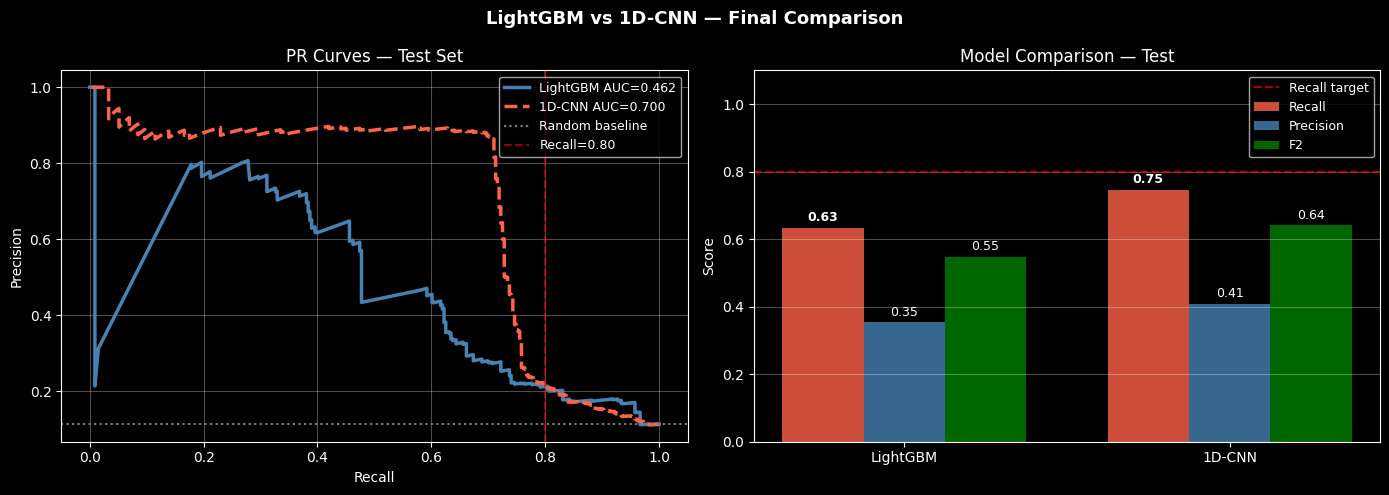

Saved: ../results/model_comparison.png


In [23]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
p_lgbm, r_lgbm, _ = precision_recall_curve(y_test, prob_test)
ax.plot(r_lgbm, p_lgbm, color='steelblue', lw=2.5,
        label=f'LightGBM AUC={np.trapezoid(p_lgbm[::-1], r_lgbm[::-1]):.3f}')
if TORCH_AVAILABLE:
    p_cnn, r_cnn, _ = precision_recall_curve(y_test, cnn_probs_test)
    ax.plot(r_cnn, p_cnn, color='tomato', lw=2.5, ls='--',
            label=f'1D-CNN AUC={np.trapezoid(p_cnn[::-1], r_cnn[::-1]):.3f}')
ax.axhline(y_test.mean(), color='gray', ls=':', lw=1.5, label='Random baseline')
ax.axvline(0.80, color='red', ls='--', alpha=0.6, label='Recall=0.80')
ax.set_xlabel('Recall'); ax.set_ylabel('Precision')
ax.set_title('PR Curves — Test Set'); ax.legend(fontsize=9); ax.grid(alpha=0.3)

ax = axes[1]
models     = ['LightGBM']
recalls    = [test_results['recall']]
precisions = [test_results['precision']]
f2s        = [test_results['f2']]

if TORCH_AVAILABLE:
    models.append('1D-CNN')
    recalls.append(cnn_test_res['recall'])
    precisions.append(cnn_test_res['precision'])
    f2s.append(cnn_test_res['f2'])

x, w = np.arange(len(models)), 0.25
ax.bar(x-w, recalls,    w, label='Recall',    color='tomato',    alpha=0.8)
ax.bar(x,   precisions, w, label='Precision', color='steelblue', alpha=0.8)
ax.bar(x+w, f2s,        w, label='F2',        color='green',     alpha=0.8)
ax.axhline(0.80, color='red', ls='--', alpha=0.7, label='Recall target')
ax.set_xticks(x); ax.set_xticklabels(models)
ax.set_ylabel('Score'); ax.set_title('Model Comparison — Test')
ax.legend(fontsize=9); ax.grid(axis='y', alpha=0.3); ax.set_ylim(0, 1.1)
for i,(r,p,f) in enumerate(zip(recalls,precisions,f2s)):
    ax.text(i-w, r+0.02, f'{r:.2f}', ha='center', fontsize=9, fontweight='bold')
    ax.text(i,   p+0.02, f'{p:.2f}', ha='center', fontsize=9)
    ax.text(i+w, f+0.02, f'{f:.2f}', ha='center', fontsize=9)

plt.suptitle('LightGBM vs 1D-CNN — Final Comparison', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('../results/model_comparison.png', dpi=120, bbox_inches='tight')
plt.show()
print('Saved: ../results/model_comparison.png')

In [ ]:
import json

model_lgbm.save_model('../models/lgbm_model.txt')
with open('../src/feature_names.json', 'w') as f:
    json.dump(feature_names, f)

summary = {
    'model': 'LightGBM',
    'W': W, 'H': H, 'dataset': DATASET_VERSION,
    'n_features':     len(feature_names),
    'threshold':      float(THRESHOLD_OPT),
    'best_iteration': model_lgbm.best_iteration,
    'val_recall':     float(val_results['recall']),
    'val_precision':  float(val_results['precision']),
    'val_f1':         float(val_results['f1']),
    'test_recall':    float(test_results['recall']),
    'test_precision': float(test_results['precision']),
    'test_f1':        float(test_results['f1']),
    'test_f2':        float(test_results['f2']),
}
with open('../src/model_summary.json', 'w') as f:
    json.dump(summary, f, indent=2)

print('=== FINAL SUMMARY ===')
for k, v in summary.items():
    print(f'  {k:<20}: {v}')

In [21]:
#Load of the data
if TORCH_AVAILABLE:
    model_cnn = CNN1D(N_METRICS, W).to(DEVICE)
    model_cnn.load_state_dict(torch.load('best_cnn.pt', map_location=DEVICE))
    model_cnn.eval()

    test_loader = make_loader(X_test_raw, y_test, shuffle=False)

    cnn_probs_test = []
    with torch.no_grad():
        for Xb, _ in test_loader:
            Xb = Xb.to(DEVICE)
            cnn_probs_test.extend(torch.sigmoid(model_cnn(Xb)).cpu().numpy())

    cnn_probs_test = np.array(cnn_probs_test)

    CNN_THRESHOLD = 0.0248
    cnn_test_res = evaluate_split(cnn_probs_test, y_test, CNN_THRESHOLD, 'CNN — Test')

else:
    print('PyTorch not available')


=== CNN — Test @ threshold=0.0248 ===
  TP=247  FP=357  TN=2237  FN=84
  Recall   : 0.7462  BELOW TARGET
  Precision: 0.4089
  F1       : 0.5283
  F2       : 0.6406
  Alert %  : 20.65%
